In [1]:
# run on gpu0
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

### Simple CNN model architecture for classification

In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

simple_cnn = Sequential()
simple_cnn.add(Conv2D(16, (3, 3), input_shape=(70, 116, 1), padding='same', activation='relu', name='conv1_1'))
simple_cnn.add(Conv2D(16, (3, 3), input_shape=(70, 116, 1), padding='same', activation='relu', name='conv1_2'))
simple_cnn.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))

simple_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2_1'))
simple_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2_2'))
simple_cnn.add(MaxPooling2D(pool_size=(5, 2), name='pool2'))

simple_cnn.add(Flatten(name='flatten'))
simple_cnn.add(Dense(32, activation='relu', name='fc1'))
simple_cnn.add(Dropout(0.5))
simple_cnn.add(Dense(1, activation='sigmoid', name='prediction'))

from keras import optimizers
adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

simple_cnn.compile(loss='binary_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

Using TensorFlow backend.


In [3]:
simple_cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1_1 (Conv2D)             (None, 70, 116, 16)       160       
_________________________________________________________________
conv1_2 (Conv2D)             (None, 70, 116, 16)       2320      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 35, 58, 16)        0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 35, 58, 32)        4640      
_________________________________________________________________
conv2_2 (Conv2D)             (None, 35, 58, 32)        9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 7, 29, 32)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6496)              0         
__________

In [ ]:
from keras.utils import plot_model
plot_model(simple_cnn, to_file='simple_cnn.png')

### Read small image files for classification

In [18]:
from keras.preprocessing.image import ImageDataGenerator

batch_size = 256

train_datagen = ImageDataGenerator(
        rotation_range=180,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
        rotation_range=180, 
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(
        'data_simple_cnn_full/train',  
        target_size=(70, 116), 
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale') 

validation_generator = test_datagen.flow_from_directory(
        'data_simple_cnn_full/validation',
        target_size=(70, 116),
        batch_size=batch_size,
        class_mode='binary',
        color_mode='grayscale')

Found 673724 images belonging to 2 classes.
Found 91395 images belonging to 2 classes.


### Classification training for small images

In [20]:
# time-consuming training process, expect to run for a long time
simple_cnn.fit_generator(
        train_generator,
        steps_per_epoch= 680000//256,
        epochs=10,
        validation_data=validation_generator,
        validation_steps=100000//256)
simple_cnn.save_weights('simple_cnn.h5')

Epoch 1/10
2656/2656 [==============================] - 492s - loss: 0.5169 - acc: 0.7502 - val_loss: 0.4733 - val_acc: 0.7773
Epoch 2/10
2656/2656 [==============================] - 492s - loss: 0.5134 - acc: 0.7529 - val_loss: 0.4683 - val_acc: 0.7793
Epoch 3/10
2656/2656 [==============================] - 493s - loss: 0.5105 - acc: 0.7542 - val_loss: 0.4688 - val_acc: 0.7770
Epoch 4/10
2656/2656 [==============================] - 495s - loss: 0.5072 - acc: 0.7564 - val_loss: 0.4628 - val_acc: 0.7817
Epoch 5/10
2656/2656 [==============================] - 492s - loss: 0.5050 - acc: 0.7584 - val_loss: 0.4606 - val_acc: 0.7838
Epoch 6/10
2656/2656 [==============================] - 490s - loss: 0.5035 - acc: 0.7591 - val_loss: 0.4611 - val_acc: 0.7836
Epoch 7/10
2656/2656 [==============================] - 491s - loss: 0.4988 - acc: 0.7618 - val_loss: 0.4637 - val_acc: 0.7797
Epoch 8/10
2656/2656 [==============================] - 495s - loss: 0.4973 - acc: 0.7632 - val_loss: 0.4522 - 

### Image segmention loss function

In [6]:
import keras.backend as K

def binary_crossentropy_with_logits(ground_truth, predictions):
    return K.mean(K.binary_crossentropy(ground_truth,
                                        predictions,
                                        from_logits=True),
                  axis=-1)

### FCN model architecture for small image segmentation

In [7]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Add, Dropout

'''
simple_cnn = Sequential()
simple_cnn.add(Conv2D(16, (3, 3), input_shape=(70, 116, 1), padding='same', activation='relu', name='conv1_1'))
simple_cnn.add(Conv2D(16, (3, 3), input_shape=(70, 116, 1), padding='same', activation='relu', name='conv1_2'))
simple_cnn.add(MaxPooling2D(pool_size=(2, 2), name='pool1'))

simple_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2_1'))
simple_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2_2'))
simple_cnn.add(MaxPooling2D(pool_size=(5, 2), name='pool2'))

simple_cnn.add(Flatten(name='flatten'))
simple_cnn.add(Dense(32, activation='relu', name='fc1'))
simple_cnn.add(Dropout(0.5))
simple_cnn.add(Dense(1, activation='sigmoid', name='prediction'))
'''
def fcn_cnn():
    fc_cnn = Sequential() 
    fc_cnn.add(Conv2D(16, (3, 3), input_shape=(70, 116, 1), padding='same', activation='relu', name='conv1_1'))
    fc_cnn.add(Conv2D(16, (3, 3), input_shape=(70, 116, 1), padding='same', activation='relu', name='conv1_2'))
    fc_cnn.add(MaxPooling2D(pool_size=(2, 2), name='pool1')) # (35, 58, 1)

    fc_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2_1'))
    fc_cnn.add(Conv2D(32, (3, 3), padding='same', activation='relu', name='conv2_2'))
    fc_cnn.add(MaxPooling2D(pool_size=(5, 2), name='pool2')) # (7, 29, 1)

    # continue to use convoluational layers instead of fully connected layers
    fc_cnn.add(Conv2D(128, (7, 29), padding='same', activation='relu', name='fc3'))
    fc_cnn.add(Dropout(0.5))
    fc_cnn.add(Conv2D(128, (1, 1), padding='same', activation='relu', name='fc4'))
    fc_cnn.add(Dropout(0.5))

    fc_cnn.add(Conv2D(2, (1, 1), padding='same', name='logit_fc4')) # [7, 29, 2]
    # deconv_logit_fc4 by factor [5, 2] to [35, 58, 2]
    fc_cnn.add(Conv2DTranspose(2, kernel_size=(2*5-5%2, 2*2-2%2), strides=(5, 2), padding='same', name='deconv_logit_fc4'))

    # conv logit from pool1 to [35, 58, 2]
    logit_pool1 = Conv2D(2, (1, 1), padding='same', name='logit_pool1')(fc_cnn.layers[2].output)
    # add deconv_logits_fc4 and logit_pool1
    logit_pool1_deconv_logit_fc4 = Add()([logit_pool1, fc_cnn.layers[-1].output])
    # deconv above sum by [2, 2] to [70, 116, 2] --> pixel-wise classification: segmentation logit
    final_deconv = Conv2DTranspose(2, kernel_size=(2*2-2%2, 2*2-2%2), strides=(2, 2), 
                                   padding='same', name='final_deconv')(logit_pool1_deconv_logit_fc4)
    
    return Model(fc_cnn.input, final_deconv)

fcn = fcn_cnn()

adam = optimizers.Adam(lr=1e-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
fcn.compile(loss=binary_crossentropy_with_logits,
              optimizer=adam,
              metrics=['accuracy'])

In [ ]:
simple_cnn.summary()

In [ ]:
# look up simple_cnn weights, do not need to run

layers = simple_cnn.layers
for i in range(len(layers)):
    n = len(layers[i].get_weights())
    print(str(i) + "-layer weight len: ", n)
    if n == 2:
        print("  weight matrix size: ", layers[i].get_weights()[0].shape)
        print("  bias vector size: ", layers[i].get_weights()[1].shape)
        print(layers[i].get_weights()[0])

In [8]:
fcn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1_1_input (InputLayer)       (None, 70, 116, 1)    0                                            
____________________________________________________________________________________________________
conv1_1 (Conv2D)                 (None, 70, 116, 16)   160         conv1_1_input[0][0]              
____________________________________________________________________________________________________
conv1_2 (Conv2D)                 (None, 70, 116, 16)   2320        conv1_1[0][0]                    
____________________________________________________________________________________________________
pool1 (MaxPooling2D)             (None, 35, 58, 16)    0           conv1_2[0][0]                    
___________________________________________________________________________________________

In [ ]:
from keras.utils import plot_model
plot_model(fcn, to_file='fcn.png')

In [ ]:
# look up fcn weights, do not need to run

layers = fcn.layers
for i in range(len(layers)):
    n = len(layers[i].get_weights())
    print(str(i) + "-layer weight len: ", n)
    if n == 2:
        print("  weight matrix size: ", layers[i].get_weights()[0].shape)
        print("  bias vector size: ", layers[i].get_weights()[1].shape)
        print(layers[i].get_weights()[0])

### Initialize weights in fcn from those in simple_cnn

In [ ]:
simple_cnn.load_weights('simple_cnn.h5')

In [9]:
def set_weights(fcn, simple_cnn):
    for i in range(5):
        fcn.layers[i+1].set_weights(simple_cnn.layers[i].get_weights())
        
set_weights(fcn, simple_cnn)

In [ ]:
# look up simple_cnn initialized weights, do not need to run

layers = fcn.layers
for i in range(len(layers)):
    n = len(layers[i].get_weights())
    print(str(i) + "-layer weight len: ", n)
    if n == 2:
        print("  weight matrix size: ", layers[i].get_weights()[0].shape)
        print("  bias vector size: ", layers[i].get_weights()[1].shape)
        print(layers[i].get_weights()[0])

### Read small image and mask files for segmentation

In [13]:
# read training data

import skimage.io as io
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

batch_size = 256

data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=180.,
                     horizontal_flip=True,
                     fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
imgs_filename = ["data_fcn_full/train/images/images/"+str(i)+".jpg" for i in range(1, 14401)]
masks_filename = ["data_fcn_full/train/masks/masks/"+str(i)+"_mask.jpg" for i in range(1, 14401)]
sample_imgs = [np.expand_dims(io.imread(img_name), -1) for img_name in imgs_filename]
sample_masks = [np.expand_dims(io.imread(mask_name), -1) for mask_name in masks_filename]
image_datagen.fit(sample_imgs, augment=True, seed=seed)
mask_datagen.fit(sample_masks, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    'data_fcn_full/train/images',
    target_size=(70, 116),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    color_mode='grayscale')

mask_generator = mask_datagen.flow_from_directory(
    'data_fcn_full/train/masks',
    target_size=(70, 116),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    color_mode='grayscale')

train_generator = zip(image_generator, mask_generator)

/home/charlioxumykj/miniconda3/envs/dlnd/lib/python3.6/site-packages/keras/preprocessing/image.py:648: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (14400, 70, 116, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Found 150000 images belonging to 1 classes.
Found 150000 images belonging to 1 classes.


In [14]:
# read validation data

data_gen_args = dict(featurewise_center=True,
                     featurewise_std_normalization=True,
                     rotation_range=180.,
                     horizontal_flip=True,
                     fill_mode='nearest')
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

seed = 1
imgs_filename = ["data_fcn_full/validation/images/images/"+str(i)+".jpg" for i in range(1, 3571)]
masks_filename = ["data_fcn_full/validation/masks/masks/"+str(i)+"_mask.jpg" for i in range(1, 3571)]
sample_imgs = [np.expand_dims(io.imread(img_name), -1) for img_name in imgs_filename]
sample_masks = [np.expand_dims(io.imread(mask_name), -1) for mask_name in masks_filename]
image_datagen.fit(sample_imgs, augment=True, seed=seed)
mask_datagen.fit(sample_masks, augment=True, seed=seed)

image_generator = image_datagen.flow_from_directory(
    'data_fcn_full/validation/images',
    target_size=(70, 116),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    color_mode='grayscale')

mask_generator = mask_datagen.flow_from_directory(
    'data_fcn_full/validation/masks',
    target_size=(70, 116),
    batch_size=batch_size,
    class_mode=None,
    seed=seed,
    color_mode='grayscale')

validation_generator = zip(image_generator, mask_generator)

/home/charlioxumykj/miniconda3/envs/dlnd/lib/python3.6/site-packages/keras/preprocessing/image.py:648: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (3570, 70, 116, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


Found 19050 images belonging to 1 classes.
Found 19050 images belonging to 1 classes.


### FCN model training on small images

In [ ]:
# time-consuming training process of fcn, expect to run for a long time

fcn.fit_generator(
    train_generator,
    steps_per_epoch=160000//256,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=19000//256)
fcn.save_weights('fcn.h5')

### FCN model prediction on small images demo

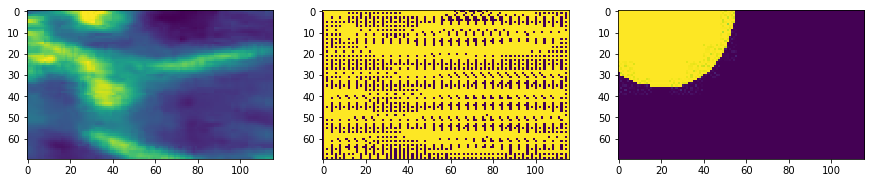

In [16]:
%matplotlib inline

import skimage.io as io
import numpy as np
import matplotlib.pyplot as plt

img = io.imread('data_fcn/validation/images/images/74.jpg') # numpy.ndarray [70, 116]
mask = io.imread('data_fcn/validation/masks/masks/74_mask.jpg')
img = np.expand_dims(img, 0)
img = np.expand_dims(img, -1)
pred = fcn.predict(img) # numpy.ndarray [1, 70, 116, 2]

# print(pred[0, :10, :10, :])

img = np.squeeze(img)
pred = np.argmax(pred, 3) # numpy.ndarray [1, 70, 116]
pred = np.squeeze(pred, 0) # numpy.ndaaray [70, 116]

# print(pred[:10, :10])

plt.figure(figsize = (15, 7))
plt.subplot(1,3,1)
plt.imshow(img)
plt.subplot(1,3,2)
plt.imshow(pred)
plt.subplot(1,3,3)
plt.imshow(mask)

### Mask detection in original images